# Mult-DAE Model

In week4 of inzva applied AI program, we build an Autoencoder model to recommend movies using MovieLens-1M data.

In [110]:
import os
import shutil
import sys

import numpy as np
from scipy import sparse

import matplotlib.pyplot as plt
%matplotlib inline
from tensorflow.contrib.layers import apply_regularization, l2_regularizer


import seaborn as sn
sn.set()

import pandas as pd
import tensorflow as tf
import bottleneck as bn


In [2]:
print(tf.__version__)

1.14.0


In [3]:
DATA_DIR = '/Users/Scoutium/Desktop/week4/ml-1m/'

In [4]:
raw_data = pd.read_csv(os.path.join(DATA_DIR, 'ratings_all.csv'), header=0)

In [5]:
raw_data = raw_data[raw_data['rating'] > 3.5]


In [6]:
raw_data.head()


,userId,movieId,rating
0,1,1193,5
3,1,3408,4
4,1,2355,5
6,1,1287,5
7,1,2804,5


In [7]:
raw_data.shape

(575281, 3)

In [8]:
def get_count(tp, id):
    playcount_groupbyid = tp[[id]].groupby(id, as_index=False)
    count = playcount_groupbyid.size()
    return count

In [9]:
def filter_triplets(tp, min_uc=5, min_sc=0):
    # Only keep the triplets for items which were clicked on by at least min_sc users. 
    if min_sc > 0:
        itemcount = get_count(tp, 'movieId')
        tp = tp[tp['movieId'].isin(itemcount.index[itemcount >= min_sc])]
    
    # Only keep the triplets for users who clicked on at least min_uc items
    # After doing this, some of the items will have less than min_uc users, but should only be a small proportion
    if min_uc > 0:
        usercount = get_count(tp, 'userId')
        tp = tp[tp['userId'].isin(usercount.index[usercount >= min_uc])]
    
    # Update both usercount and itemcount after filtering
    usercount, itemcount = get_count(tp, 'userId'), get_count(tp, 'movieId') 
    return tp, usercount, itemcount

In [10]:
raw_data, user_activity, item_popularity = filter_triplets(raw_data)

In [11]:
raw_data.shape

(575272, 3)

In [12]:
sparsity = 1. * raw_data.shape[0] / (user_activity.shape[0] * item_popularity.shape[0])

print("After filtering, there are %d watching events from %d users and %d movies (sparsity: %.3f%%)" % 
      (raw_data.shape[0], user_activity.shape[0], item_popularity.shape[0], sparsity * 100))

After filtering, there are 575272 watching events from 6034 users and 3533 movies (sparsity: 2.699%)


In [13]:
unique_uid = user_activity.index

np.random.seed(98765)
idx_perm = np.random.permutation(unique_uid.size)
unique_uid = unique_uid[idx_perm]

In [14]:
# create train/validation/test users
n_users = unique_uid.size
n_heldout_users = 1000

tr_users = unique_uid[:(n_users - n_heldout_users * 2)]
vd_users = unique_uid[(n_users - n_heldout_users * 2): (n_users - n_heldout_users)]
te_users = unique_uid[(n_users - n_heldout_users):]

In [15]:
vd_users

Int64Index([4805,  932, 4025, 3797, 4123, 5765, 2607,  840,  559, 5445,
            ...
            2740, 1675, 3588, 4742, 5145, 1353,  812, 5291, 4818, 2475],
           dtype='int64', name='userId', length=1000)

In [16]:
train_plays = raw_data.loc[raw_data['userId'].isin(tr_users)]

In [17]:
train_plays

,userId,movieId,rating
0,1,1193,5
3,1,3408,4
4,1,2355,5
6,1,1287,5
7,1,2804,5
...,...,...,...
1000202,6040,1089,4
1000205,6040,1094,5
1000206,6040,562,5
1000207,6040,1096,4


In [18]:
unique_sid = pd.unique(train_plays['movieId'])

In [19]:
unique_sid

array([1193, 3408, 2355, ..., 2909, 1434, 2198])

In [20]:
show2id = dict((sid, i) for (i, sid) in enumerate(unique_sid))
profile2id = dict((pid, i) for (i, pid) in enumerate(unique_uid))

In [21]:
pro_dir = os.path.join(DATA_DIR, 'pro_sg')

if not os.path.exists(pro_dir):
    os.makedirs(pro_dir)

with open(os.path.join(pro_dir, 'unique_sid.txt'), 'w') as f:
    for sid in unique_sid:
        f.write('%s\n' % sid)

In [22]:
def split_train_test_proportion(data, test_prop=0.2):
    data_grouped_by_user = data.groupby('userId')
    tr_list, te_list = list(), list()

    np.random.seed(98765)

    for i, (_, group) in enumerate(data_grouped_by_user):
        n_items_u = len(group)

        if n_items_u >= 5:
            idx = np.zeros(n_items_u, dtype='bool')
            idx[np.random.choice(n_items_u, size=int(test_prop * n_items_u), replace=False).astype('int64')] = True

            tr_list.append(group[np.logical_not(idx)])
            te_list.append(group[idx])
        else:
            tr_list.append(group)

        if i % 100 == 0:
            print("%d users sampled" % i)
            sys.stdout.flush()

    data_tr = pd.concat(tr_list)
    data_te = pd.concat(te_list)
    
    return data_tr, data_te

In [23]:
vad_plays = raw_data.loc[raw_data['userId'].isin(vd_users)]


In [24]:
vad_plays

,userId,movieId,rating
556,8,288,5
559,8,1466,4
560,8,1393,5
561,8,1682,4
562,8,2916,5
...,...,...,...
997288,6022,1036,5
997292,6022,1079,4
997293,6022,2028,5
997294,6022,1089,5


In [25]:
vad_plays = vad_plays.loc[vad_plays['movieId'].isin(unique_sid)]

In [26]:
unique_sid

array([1193, 3408, 2355, ..., 2909, 1434, 2198])

In [27]:
vad_plays_tr, vad_plays_te = split_train_test_proportion(vad_plays)

0 users sampled
100 users sampled
200 users sampled
300 users sampled
400 users sampled
500 users sampled
600 users sampled
700 users sampled
800 users sampled
900 users sampled


In [28]:
test_plays = raw_data.loc[raw_data['userId'].isin(te_users)]
test_plays = test_plays.loc[test_plays['movieId'].isin(unique_sid)]

In [29]:
test_plays_tr, test_plays_te = split_train_test_proportion(test_plays)


0 users sampled
100 users sampled
200 users sampled
300 users sampled
400 users sampled
500 users sampled
600 users sampled
700 users sampled
800 users sampled
900 users sampled


In [30]:
def numerize(tp):
    print(tp.head())
    uid = list(map(lambda x: profile2id[x], tp['userId']))
    sid = list(map(lambda x: show2id[x], tp['movieId']))
    return pd.DataFrame(data={'uid': uid, 'sid': sid}, columns=['uid', 'sid'])

In [31]:
train_data = numerize(train_plays)
train_data.to_csv(os.path.join(pro_dir, 'train.csv'), index=False)

   userId  movieId  rating
0       1     1193       5
3       1     3408       4
4       1     2355       5
6       1     1287       5
7       1     2804       5


In [32]:
train_data

,uid,sid
0,1102,0
1,1102,1
2,1102,2
3,1102,3
4,1102,4
...,...,...
388241,3466,188
388242,3466,547
388243,3466,203
388244,3466,100


In [33]:
vad_data_tr = numerize(vad_plays_tr)
vad_data_tr.to_csv(os.path.join(pro_dir, 'validation_tr.csv'), index=False)

     userId  movieId  rating
556       8      288       5
560       8     1393       5
561       8     1682       4
562       8     2916       5
567       8      650       5


In [34]:
vad_data_te = numerize(vad_plays_te)
vad_data_te.to_csv(os.path.join(pro_dir, 'validation_te.csv'), index=False)

     userId  movieId  rating
559       8     1466       4
576       8      589       5
579       8      150       4
596       8     2571       5
597       8     1916       5


In [35]:
test_data_tr = numerize(test_plays_tr)
test_data_tr.to_csv(os.path.join(pro_dir, 'test_tr.csv'), index=False)

     userId  movieId  rating
233       4     3468       5
236       4     1214       4
238       4      260       5
240       4      480       4
242       4     1198       5


In [36]:
test_data_te = numerize(test_plays_te)
test_data_te.to_csv(os.path.join(pro_dir, 'test_te.csv'), index=False)

     userId  movieId  rating
235       4     2951       4
237       4     1036       4
239       4     2028       5
523       7      648       4
545       7     1722       4


In [51]:
class MultiDAE(object):
    def __init__(self, p_dims, q_dims=None, lam=0.01, lr=1e-3, random_seed=None):
        self.p_dims = p_dims
        if q_dims is None:
            self.q_dims = p_dims[::-1]
        else:
            assert q_dims[0] == p_dims[-1], "Input and output dimension must equal each other for autoencoders."
            assert q_dims[-1] == p_dims[0], "Latent dimension for p- and q-network mismatches."
            self.q_dims = q_dims
        self.dims = self.q_dims + self.p_dims[1:]
        
        self.lam = lam
        self.lr = lr
        self.random_seed = random_seed

        self.construct_placeholders()

    def construct_placeholders(self):        
        self.input_ph = tf.placeholder(
            dtype=tf.float32, shape=[None, self.dims[0]])
        self.keep_prob_ph = tf.placeholder_with_default(1.0, shape=None)

    def build_graph(self):

        self.construct_weights()

        saver, logits = self.forward_pass()
        log_softmax_var = tf.nn.log_softmax(logits)

        # per-user average negative log-likelihood
        # we calculate the loss using whole set of input data
        # it is a hidden 'regularization'!!!!!!!!!
        neg_ll = -tf.reduce_mean(tf.reduce_sum(
            log_softmax_var * self.input_ph, axis=1))
        # apply regularization to weights
        reg = l2_regularizer(self.lam)
        reg_var = apply_regularization(reg, self.weights)
        # tensorflow l2 regularization multiply 0.5 to the l2 norm
        # multiply 2 so that it is back in the same scale
        loss = neg_ll + 2 * reg_var
        
        train_op = tf.train.AdamOptimizer(self.lr).minimize(loss)

        # add summary statistics
        tf.summary.scalar('negative_multi_ll', neg_ll)
        tf.summary.scalar('loss', loss)
        merged = tf.summary.merge_all()
        return saver, logits, loss, train_op, merged

    def forward_pass(self):
        # construct forward graph        
        h = tf.nn.l2_normalize(self.input_ph, 1)
        # this is where denoising property comes!
        h = tf.nn.dropout(h, self.keep_prob_ph)
        
        for i, (w, b) in enumerate(zip(self.weights, self.biases)):
            h = tf.matmul(h, w) + b
            
            if i != len(self.weights) - 1:
                h = tf.nn.tanh(h)
        return tf.train.Saver(), h

    def construct_weights(self):

        self.weights = []
        self.biases = []
        
        # define weights
        for i, (d_in, d_out) in enumerate(zip(self.dims[:-1], self.dims[1:])):
            weight_key = "weight_{}to{}".format(i, i+1)
            bias_key = "bias_{}".format(i+1)
            
            self.weights.append(tf.get_variable(
                name=weight_key, shape=[d_in, d_out],
                initializer=tf.contrib.layers.xavier_initializer(
                    seed=self.random_seed)))
            
            self.biases.append(tf.get_variable(
                name=bias_key, shape=[d_out],
                initializer=tf.truncated_normal_initializer(
                    stddev=0.001, seed=self.random_seed)))
            
            # add summary stats
            tf.summary.histogram(weight_key, self.weights[-1])
            tf.summary.histogram(bias_key, self.biases[-1])

In [38]:
unique_sid = list()
with open(os.path.join(pro_dir, 'unique_sid.txt'), 'r') as f:
    for line in f:
        unique_sid.append(line.strip())

n_items = len(unique_sid)

In [39]:
def load_train_data(csv_file):
    tp = pd.read_csv(csv_file)
    n_users = tp['uid'].max() + 1

    rows, cols = tp['uid'], tp['sid']
    data = sparse.csr_matrix((np.ones_like(rows),
                             (rows, cols)), dtype='float64',
                             shape=(n_users, n_items))
    return data

In [40]:
train_data = load_train_data(os.path.join(pro_dir, 'train.csv'))

In [41]:

def load_tr_te_data(csv_file_tr, csv_file_te):
    tp_tr = pd.read_csv(csv_file_tr)
    tp_te = pd.read_csv(csv_file_te)

    start_idx = min(tp_tr['uid'].min(), tp_te['uid'].min())
    end_idx = max(tp_tr['uid'].max(), tp_te['uid'].max())

    rows_tr, cols_tr = tp_tr['uid'] - start_idx, tp_tr['sid']
    rows_te, cols_te = tp_te['uid'] - start_idx, tp_te['sid']

    data_tr = sparse.csr_matrix((np.ones_like(rows_tr),
                             (rows_tr, cols_tr)), dtype='float64', shape=(end_idx - start_idx + 1, n_items))
    data_te = sparse.csr_matrix((np.ones_like(rows_te),
                             (rows_te, cols_te)), dtype='float64', shape=(end_idx - start_idx + 1, n_items))
    return data_tr, data_te

In [42]:
vad_data_tr, vad_data_te = load_tr_te_data(os.path.join(pro_dir, 'validation_tr.csv'),
                                           os.path.join(pro_dir, 'validation_te.csv'))

In [43]:
N = train_data.shape[0]
idxlist = range(N)

# training batch size
batch_size = 500
batches_per_epoch = int(np.ceil(float(N) / batch_size))

N_vad = vad_data_tr.shape[0]
idxlist_vad = range(N_vad)

# validation batch size (since the entire validation set might not fit into GPU memory)
batch_size_vad = 2000

# the total number of gradient updates for annealing
total_anneal_steps = 200000
# largest annealing parameter
anneal_cap = 0.2

In [44]:
def NDCG_binary_at_k_batch(X_pred, heldout_batch, k=100):
    '''
    normalized discounted cumulative gain@k for binary relevance
    ASSUMPTIONS: all the 0's in heldout_data indicate 0 relevance
    '''
    batch_users = X_pred.shape[0]
    idx_topk_part = bn.argpartition(-X_pred, k, axis=1)
    topk_part = X_pred[np.arange(batch_users)[:, np.newaxis],
                       idx_topk_part[:, :k]]
    idx_part = np.argsort(-topk_part, axis=1)
    # X_pred[np.arange(batch_users)[:, np.newaxis], idx_topk] is the sorted
    # topk predicted score
    idx_topk = idx_topk_part[np.arange(batch_users)[:, np.newaxis], idx_part]
    # build the discount template
    tp = 1. / np.log2(np.arange(2, k + 2))

    DCG = (heldout_batch[np.arange(batch_users)[:, np.newaxis],
                         idx_topk].toarray() * tp).sum(axis=1)
    IDCG = np.array([(tp[:min(n, k)]).sum()
                     for n in heldout_batch.getnnz(axis=1)])
    return DCG / IDCG

In [108]:
def Recall_at_k_batch(X_pred, heldout_batch, k=100):
    batch_users = X_pred.shape[0]

    idx = bn.argpartition(-X_pred, k, axis=1)
    X_pred_binary = np.zeros_like(X_pred, dtype=bool)
    X_pred_binary[np.arange(batch_users)[:, np.newaxis], idx[:, :k]] = True
    print(X_pred_binary)
    X_true_binary = (heldout_batch > 0).toarray()
    tmp = (np.logical_and(X_true_binary, X_pred_binary).sum(axis=1)).astype(
        np.float32)
    recall = tmp / np.minimum(k, X_true_binary.sum(axis=1))
    return recall

In [46]:
p_dims = [200, n_items]

In [47]:
#import tensorflow.compat.v1 as tf
#tf.disable_v2_behavior() 

In [92]:
tf.reset_default_graph() 
dae = MultiDAE(p_dims, lam=0.01 / batch_size, random_seed=98765)

saver, logits_var, loss_var, train_op_var, merged_var = dae.build_graph()

ndcg_var = tf.Variable(0.0)
ndcg_dist_var = tf.placeholder(dtype=tf.float64, shape=None)
ndcg_summary = tf.summary.scalar('ndcg_at_k_validation', ndcg_var)
ndcg_dist_summary = tf.summary.histogram('ndcg_at_k_hist_validation', ndcg_dist_var)
merged_valid = tf.summary.merge([ndcg_summary, ndcg_dist_summary])

In [93]:
arch_str = "I-%s-I" % ('-'.join([str(d) for d in dae.dims[1:-1]]))


In [94]:
log_dir = '/Users/Scoutium/Desktop/week4/ml-1m/DAE/{}'.format(arch_str)

if os.path.exists(log_dir):
    shutil.rmtree(log_dir)

print("log directory: %s" % log_dir)
summary_writer = tf.summary.FileWriter(log_dir, graph=tf.get_default_graph())

log directory: /Users/Scoutium/Desktop/week4/ml-1m/DAE/I-200-I


In [95]:
chkpt_dir = '/Users/Scoutium/Desktop/week4/ml-1m/DAE/{}'.format(arch_str)

if not os.path.isdir(chkpt_dir):
    os.makedirs(chkpt_dir) 
    
print("chkpt directory: %s" % chkpt_dir)

chkpt directory: /Users/Scoutium/Desktop/week4/ml-1m/DAE/I-200-I


In [96]:
n_epochs = 100

In [97]:
ndcgs_vad = []

with tf.Session() as sess:

    init = tf.global_variables_initializer()
    sess.run(init)

    best_ndcg = -np.inf
    
    for epoch in range(n_epochs):
        np.random.shuffle(list(idxlist))
        # train for one epoch
        for bnum, st_idx in enumerate(range(0, N, batch_size)):
            end_idx = min(st_idx + batch_size, N)
            X = train_data[idxlist[st_idx:end_idx]]
            
            if sparse.isspmatrix(X):
                X = X.toarray()
            X = X.astype('float32')           
            
            feed_dict = {dae.input_ph: X, 
                         dae.keep_prob_ph: 0.5}        
            sess.run(train_op_var, feed_dict=feed_dict)

            if bnum % 100 == 0:
                summary_train = sess.run(merged_var, feed_dict=feed_dict)
                summary_writer.add_summary(summary_train, global_step=epoch * batches_per_epoch + bnum) 
                    
        # compute validation NDCG
        ndcg_dist = []
        for bnum, st_idx in enumerate(range(0, N_vad, batch_size_vad)):
            end_idx = min(st_idx + batch_size_vad, N_vad)
            X = vad_data_tr[idxlist_vad[st_idx:end_idx]]

            if sparse.isspmatrix(X):
                X = X.toarray()
            X = X.astype('float32')
        
            pred_val = sess.run(logits_var, feed_dict={dae.input_ph: X} )
            # exclude examples from training and validation (if any)
            pred_val[X.nonzero()] = -np.inf
            ndcg_dist.append(NDCG_binary_at_k_batch(pred_val, vad_data_te[idxlist_vad[st_idx:end_idx]]))
        
        ndcg_dist = np.concatenate(ndcg_dist)
        ndcg_ = ndcg_dist.mean()
        ndcgs_vad.append(ndcg_)
        merged_valid_val = sess.run(merged_valid, feed_dict={ndcg_var: ndcg_, ndcg_dist_var: ndcg_dist})
        summary_writer.add_summary(merged_valid_val, epoch)

        # update the best model (if necessary)
        if ndcg_ > best_ndcg:
            saver.save(sess, '{}/model'.format(chkpt_dir))
            best_ndcg = ndcg_

HEYY
range(0, 4034)
HEYY
range(0, 4034)
HEYY
range(0, 4034)
HEYY
range(0, 4034)
HEYY
range(0, 4034)
HEYY
range(0, 4034)
HEYY
range(0, 4034)
HEYY
range(0, 4034)
HEYY
range(0, 4034)
HEYY
range(0, 4034)
HEYY
range(0, 4034)
HEYY
range(0, 4034)
HEYY
range(0, 4034)
HEYY
range(0, 4034)
HEYY
range(0, 4034)
HEYY
range(0, 4034)
HEYY
range(0, 4034)
HEYY
range(0, 4034)
HEYY
range(0, 4034)
HEYY
range(0, 4034)
HEYY
range(0, 4034)
HEYY
range(0, 4034)
HEYY
range(0, 4034)
HEYY
range(0, 4034)
HEYY
range(0, 4034)
HEYY
range(0, 4034)
HEYY
range(0, 4034)
HEYY
range(0, 4034)
HEYY
range(0, 4034)
HEYY
range(0, 4034)
HEYY
range(0, 4034)
HEYY
range(0, 4034)
HEYY
range(0, 4034)
HEYY
range(0, 4034)
HEYY
range(0, 4034)
HEYY
range(0, 4034)
HEYY
range(0, 4034)
HEYY
range(0, 4034)
HEYY
range(0, 4034)
HEYY
range(0, 4034)
HEYY
range(0, 4034)
HEYY
range(0, 4034)
HEYY
range(0, 4034)
HEYY
range(0, 4034)
HEYY
range(0, 4034)
HEYY
range(0, 4034)
HEYY
range(0, 4034)
HEYY
range(0, 4034)
HEYY
range(0, 4034)
HEYY
range(0, 4034)


In [71]:
for x in range(1):
    print(x)

0


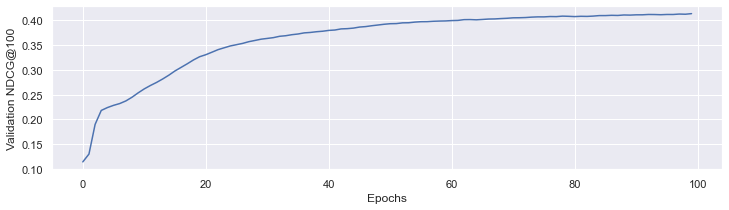

In [98]:
plt.figure(figsize=(12, 3))
plt.plot(ndcgs_vad)
plt.ylabel("Validation NDCG@100")
plt.xlabel("Epochs")
pass

In [99]:
test_data_tr, test_data_te = load_tr_te_data(
    os.path.join(pro_dir, 'test_tr.csv'),
    os.path.join(pro_dir, 'test_te.csv'))

In [100]:
N_test = test_data_tr.shape[0]
idxlist_test = range(N_test)

batch_size_test = 200

In [101]:
tf.reset_default_graph()
dae = MultiDAE(p_dims, lam=0.01 / batch_size)
saver, logits_var, _, _, _ = dae.build_graph()

In [102]:
chkpt_dir = '/Users/Scoutium/Desktop/week4/ml-1m/DAE/{}'.format(arch_str)
print("chkpt directory: %s" % chkpt_dir)

chkpt directory: /Users/Scoutium/Desktop/week4/ml-1m/DAE/I-200-I


In [109]:
n100_list, r20_list, r50_list = [], [], []

with tf.Session() as sess:    
    saver.restore(sess, '{}/model'.format(chkpt_dir))
    
    for bnum, st_idx in enumerate(range(0, N_test, batch_size_test)):
        end_idx = min(st_idx + batch_size_test, N_test)
        X = test_data_tr[idxlist_test[st_idx:end_idx]]

        if sparse.isspmatrix(X):
            X = X.toarray()
        X = X.astype('float32')

        pred_val = sess.run(logits_var, feed_dict={dae.input_ph: X})
        # exclude examples from training and validation (if any)
        pred_val[X.nonzero()] = -np.inf
        n100_list.append(NDCG_binary_at_k_batch(pred_val, test_data_te[idxlist_test[st_idx:end_idx]], k=100))
        r20_list.append(Recall_at_k_batch(pred_val, test_data_te[idxlist_test[st_idx:end_idx]], k=20))
        r50_list.append(Recall_at_k_batch(pred_val, test_data_te[idxlist_test[st_idx:end_idx]], k=50))

n100_list = np.concatenate(n100_list)
r20_list = np.concatenate(r20_list)
r50_list = np.concatenate(r50_list)

INFO:tensorflow:Restoring parameters from /Users/Scoutium/Desktop/week4/ml-1m/DAE/I-200-I/model
[[False False False ... False False False]
 [ True False False ... False False False]
 [False False False ... False False False]
 ...
 [ True False False ... False False False]
 [False False False ... False False False]
 [ True False False ... False False False]]
[[ True False False ... False False False]
 [ True False  True ... False False False]
 [False False False ... False False False]
 ...
 [ True False False ... False False False]
 [False False False ... False False False]
 [ True False False ... False False False]]
[[False False False ... False False False]
 [False False False ... False False False]
 [False False False ... False False False]
 ...
 [ True False False ... False False False]
 [ True False False ... False False False]
 [False False False ... False False False]]
[[False False False ... False False False]
 [ True False False ... False False False]
 [False False False ... Fa

In [104]:
print("Test NDCG@100=%.5f (%.5f)" % (np.mean(n100_list), np.std(n100_list) / np.sqrt(len(n100_list))))
print("Test Recall@20=%.5f (%.5f)" % (np.mean(r20_list), np.std(r20_list) / np.sqrt(len(r20_list))))
print("Test Recall@50=%.5f (%.5f)" % (np.mean(r50_list), np.std(r50_list) / np.sqrt(len(r50_list))))

Test NDCG@100=0.40384 (0.00551)
Test Recall@20=0.33929 (0.00658)
Test Recall@50=0.45634 (0.00717)


In [106]:
pred_val.shape

(200, 3468)